In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def load_pair(tissue_num, samp_num, kind="salmon_all_default"):
    meth = kind.split('_')[0]
    if meth == 'salmon':
        qf = 'quant.sf'
        nk = 'Name'
        rename_fun = lambda x : x
    elif meth == 'kallisto':
        qf = 'abundance.tsv'
        nk = 'Name'
        rename_fun = lambda x : x.rename(columns={'target_id': 'Name', 'est_counts' : 'NumReads', 'tpm' : 'TPM'})
    else:
        print("unknown method {}".format(meth))
        
    p = pd.read_csv("../quants/tissue{}/sample{}/{}/{}".format(tissue_num, samp_num, kind, qf), sep="\t")
    p = rename_fun(p)
    t = pd.read_csv("../simulated_reads/tissue{}/sample{}/all_true_counts.tsv".format(tissue_num, samp_num), sep="\t")
    j = pd.merge(t, p, left_on='tname', right_on=nk, how="outer").fillna(0.0)
    return j

In [189]:
def load_quant(tissue_num, samp_num, kind="salmon_all_default"):
    meth = kind.split('_')[0]
    if meth == 'salmon':
        qf = 'quant.sf'
        nk = 'Name'
        rename_fun = lambda x : x
    elif meth == 'kallisto':
        qf = 'abundance.tsv'
        nk = 'Name'
        rename_fun = lambda x : x.rename(columns={'target_id': 'Name', 'est_counts' : 'NumReads', 'tpm' : 'TPM'})
    else:
        print("unknown method {}".format(meth))
        
    p = pd.read_csv("../quants/tissue{}/sample{}/{}/{}".format(tissue_num, samp_num, kind, qf), sep="\t")
    p = rename_fun(p)
    return p

In [438]:
def get_fp_fn(j):
    fn = j.loc[ (j['Name'].str.startswith('CHS')) & (j['true_count'] > 0 ) & (j['NumReads'] == 0)].shape[0]
    fp = j.loc[ (j['Name'].str.startswith('CHS')) & (j['true_count'] == 0 ) & (j['NumReads'] > 0)].shape[0]
    tp = j.loc[ (j['Name'].str.startswith('CHS')) & (j['true_count'] > 0 ) & (j['NumReads'] > 0)].shape[0]
    tn = j.loc[ (j['Name'].str.startswith('CHS')) & (j['true_count'] == 0 ) & (j['NumReads'] == 0)].shape[0]
    return (fp, fn, tp, tn)

In [371]:
def clean_names(df):
    df = df.replace('salmon_default_all', 'salmon (all)')
    df = df.replace('salmon_default_real', 'salmon (real)')

    df = df.replace('salmon_em_all', 'salmon-em (all)')
    df = df.replace('salmon_em_real', 'salmon-em (real)')

    df = df.replace('salmon_nodecoy_all', 'salmon-reduced (all)')
    df = df.replace('salmon_nodecoy_real', 'salmon-reduced (real)')

    df = df.replace('salmon_nodecoy_all_em', 'salmon-reduced-em (all)')
    df = df.replace('salmon_nodecoy_real_em', 'salmon-reduced-em (real)')

    df = df.replace('kallisto_default_all', 'kallisto (all)')
    df = df.replace('kallisto_default_real', 'kallisto (real)')

    df = df.replace('kallisto_default_stranded_all', 'kallisto-stranded (all)')
    df = df.replace('kallisto_default_stranded_real', 'kallisto-stranded (real)')
    return df

In [ ]:
def get_f1(fp, fn, tp, tn):
    return tp / (tp + 0.5 * (fp + fn))

In [102]:
sns.set_theme(context='paper', style='white', palette=sns.color_palette('nipy_spectral'))

In [83]:
dat_s = []
for t in range(3):
    for s in range(10):
        for m in ['salmon', 'kallisto']:
            j = load_pair(t, s, "{}_all_default".format(m))
            fp, fn, tp, tn = get_fp_fn(j)
            dat_s.append( ('fp', '{}_default_all'.format(m), fp) )
            dat_s.append( ('fn', '{}_default_all'.format(m), fn) )
            dat_s.append( ('tp', '{}_default_all'.format(m), tp) )
            dat_s.append( ('tn', '{}_default_all'.format(m), tn) )
            dat_s.append( ('f1', '{}_default_all'.format(m), get_f1(fp, fn, tp, tn)) )
            
            j = load_pair(t, s, "{}_real_default".format(m))
            fp, fn, tp, tn = get_fp_fn(j)
            dat_s.append( ('fp', '{}_default_real'.format(m), fp) )
            dat_s.append( ('fn', '{}_default_real'.format(m), fn) )
            dat_s.append( ('tp', '{}_default_real'.format(m), tp) )
            dat_s.append( ('tn', '{}_default_real'.format(m), tn) )
            dat_s.append( ('f1', '{}_default_real'.format(m), get_f1(fp, fn, tp, tn)) )

            if m == "salmon":
                j = load_pair(t, s, "{}_all_em".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_em_all'.format(m), fp) )
                dat_s.append( ('fn', '{}_em_all'.format(m), fn) )
                dat_s.append( ('tp', '{}_em_all'.format(m), tp) )
                dat_s.append( ('tn', '{}_em_all'.format(m), tn) )
                dat_s.append( ('f1', '{}_em_all'.format(m), get_f1(fp, fn, tp, tn)) )
                
                j = load_pair(t, s, "{}_real_em".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_em_real'.format(m), fp) )
                dat_s.append( ('fn', '{}_em_real'.format(m), fn) )
                dat_s.append( ('tp', '{}_em_real'.format(m), tp) )
                dat_s.append( ('tn', '{}_em_real'.format(m), tn) )
                dat_s.append( ('f1', '{}_em_real'.format(m), get_f1(fp, fn, tp, tn)) )
                
                j = load_pair(t, s, "{}_all_nodecoy_default".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_nodecoy_all'.format(m), fp) )
                dat_s.append( ('fn', '{}_nodecoy_all'.format(m), fn) )
                dat_s.append( ('tp', '{}_nodecoy_all'.format(m), tp) )
                dat_s.append( ('tn', '{}_nodecoy_all'.format(m), tn) )
                dat_s.append( ('f1', '{}_nodecoy_all'.format(m), get_f1(fp, fn, tp, tn)) )
                
                j = load_pair(t, s, "{}_real_nodecoy_default".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_nodecoy_real'.format(m), fp) )
                dat_s.append( ('fn', '{}_nodecoy_real'.format(m), fn) )
                dat_s.append( ('tp', '{}_nodecoy_real'.format(m), tp) )
                dat_s.append( ('tn', '{}_nodecoy_real'.format(m), tn) )
                dat_s.append( ('f1', '{}_nodecoy_real'.format(m), get_f1(fp, fn, tp, tn)) )
                
                j = load_pair(t, s, "{}_all_nodecoy_em".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_nodecoy_all_em'.format(m), fp) )
                dat_s.append( ('fn', '{}_nodecoy_all_em'.format(m), fn) )
                dat_s.append( ('tp', '{}_nodecoy_all_em'.format(m), tp) )
                dat_s.append( ('tn', '{}_nodecoy_all_em'.format(m), tn) )
                dat_s.append( ('f1', '{}_nodecoy_all_em'.format(m), get_f1(fp, fn, tp, tn)) )
                
                j = load_pair(t, s, "{}_real_nodecoy_em".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_nodecoy_real_em'.format(m), fp) )
                dat_s.append( ('fn', '{}_nodecoy_real_em'.format(m), fn) )
                dat_s.append( ('tp', '{}_nodecoy_real_em'.format(m), tp) )
                dat_s.append( ('tn', '{}_nodecoy_real_em'.format(m), tn) )
                dat_s.append( ('f1', '{}_nodecoy_real_em'.format(m), get_f1(fp, fn, tp, tn)) )
                
            elif m == "kallisto":
                j = load_pair(t, s, "{}_all_stranded_default".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_default_stranded_all'.format(m), fp) )
                dat_s.append( ('fn', '{}_default_stranded_all'.format(m), fn) )
                dat_s.append( ('tp', '{}_default_stranded_all'.format(m), tp) )
                dat_s.append( ('tn', '{}_default_stranded_all'.format(m), tn) )
                dat_s.append( ('f1', '{}_default_stranded_all'.format(m), get_f1(fp, fn, tp, tn)) )

                j = load_pair(t, s, "{}_real_stranded_default".format(m))
                fp, fn, tp, tn = get_fp_fn(j)
                dat_s.append( ('fp', '{}_default_stranded_real'.format(m), fp) )
                dat_s.append( ('fn', '{}_default_stranded_real'.format(m), fn) )
                dat_s.append( ('tp', '{}_default_stranded_real'.format(m), tp) )
                dat_s.append( ('tn', '{}_default_stranded_real'.format(m), tn) )
                dat_s.append( ('f1', '{}_default_stranded_real'.format(m), get_f1(fp, fn, tp, tn)) )

In [321]:
ds2 = clean_names(pd.DataFrame(dat_s, columns=['measure', 'method', 'value']))

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


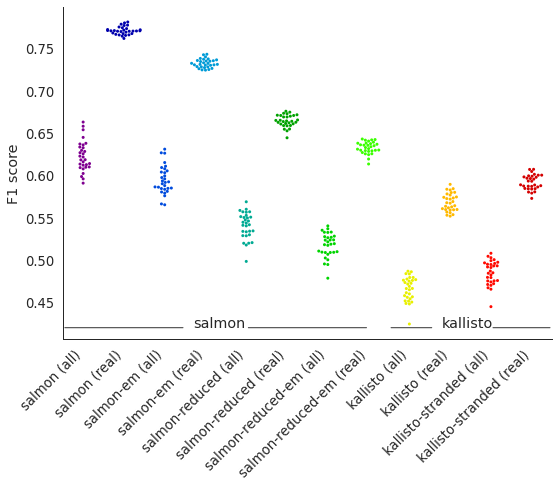

In [474]:
with sns.plotting_context("paper", font_scale=1.5):
    plt.figure(figsize=(8,7))
    ax = sns.swarmplot(data=ds2.loc[ds2.measure.str.contains('f1'), :], x='method', y='value', hue='method',\
                        palette='nipy_spectral', size=3)

    ax.annotate('salmon', xy=(2.7,0.42), xytext=(2.7,0.42))
    ax.annotate("", xy=(-0.5, 0.42), xytext=(2.5,0.42),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    ax.annotate("", xy=(7.0, 0.42), xytext=(4.0,0.42),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    
    ax.annotate('kallisto', xy=(8.8, 0.42), xytext=(8.8, 0.42))
    ax.annotate("", xy=(7.5, 0.42), xytext=(8.6,0.42),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    ax.annotate("", xy=(10.0, 0.42), xytext=(11.5,0.42),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

    plt.gca().get_legend().remove()
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")
    plt.ylabel('F1 score')
    sns.despine()
    plt.tight_layout()
    plt.savefig('../figures/f1.pdf')

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


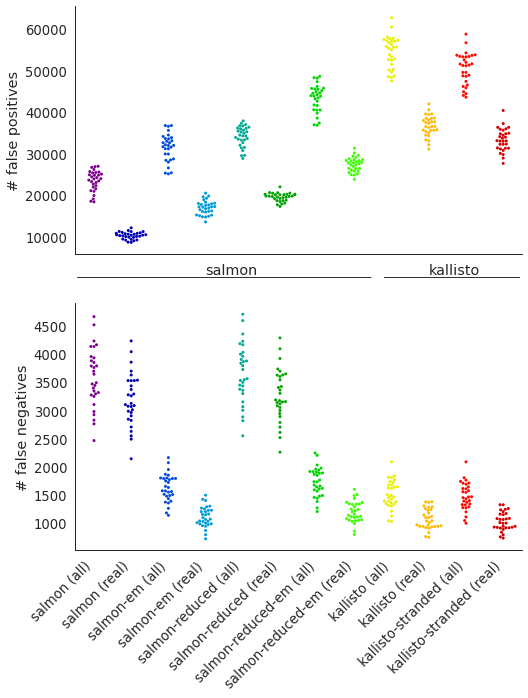

In [366]:
ds = clean_names(pd.DataFrame(dat_s, columns=['measure', 'method', 'value']))
with sns.plotting_context("paper", font_scale=1.5):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), 
                             gridspec_kw=dict(height_ratios=(1, 1), hspace=0.2))
    sns.swarmplot(data=ds.loc[ds.measure.str.contains('fp'), :], size=3, x='method', y='value', hue='method',\
                   palette='nipy_spectral', ax=axes[0])
    
    axes[0].set_ylabel('# false positives')
    axes[0].get_legend().remove()
    axes[0].set_xticks([])
    axes[0].set_xlabel('')
        
    sns.swarmplot(data=ds.loc[ds.measure.str.contains('fn'), :], size=3, x='method', y='value', hue='method',\
                   palette='nipy_spectral', ax=axes[1])
    axes[1].get_legend().remove()
    axes[1].set_ylabel('# false negatives')

    plt.xticks(rotation=45, ha='right')
    
    axes[0].annotate('salmon', xy=(3,1000), xytext=(3,1000), textcoords='data', xycoords='data', annotation_clip=False)#, bbox=dict(boxstyle ="round", fc ="0.8"))
    axes[0].annotate("", xy=(-0.5,200), xytext=(7.5,200),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'),
                annotation_clip=False)
    axes[0].annotate('kallisto', xy=(9,1000), xytext=(9,1000), textcoords='data', xycoords='data', annotation_clip=False)#, bbox=dict(boxstyle ="round", fc ="0.8"))
    axes[0].annotate("", xy=(7.75,200), xytext=(11.5,200),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'),
                annotation_clip=False)
 
    axes[1].set_xlabel('')
    sns.despine()
    plt.savefig('../figures/fp_fn.pdf', bbox_inches="tight")

In [375]:
z = clean_names(pd.DataFrame(dat_s, columns=['measure', 'method', 'value']))
metric_means = z.groupby(['method', 'measure']).mean()
metric_means.loc[('salmon (real)', 'fp')], metric_means.loc[('salmon-em (real)', 'fp')]

Show average FP/FN for different methods in "all" and "real" sets

In [426]:
z.loc[ (z['method'].str.split(' ').str.get(1) == '(all)') & (z['measure'].isin(['fp', 'fn'])), :].groupby(['method', 'measure']).mean()

value
method                  measure              
kallisto (all)          fn        1507.066667
                        fp       54426.800000
kallisto-stranded (all) fn        1473.666667
                        fp       50462.500000
salmon (all)            fn        3582.266667
                        fp       23485.700000
salmon-em (all)         fn        1626.200000
                        fp       31470.033333
salmon-reduced (all)    fn        3658.000000
                        fp       34111.566667
salmon-reduced-em (all) fn        1729.766667
                        fp       43321.666667

In [427]:
z.loc[ (z['method'].str.split(' ').str.get(1) == '(real)') & (z['measure'].isin(['fp', 'fn'])), :].groupby(['method', 'measure']).mean()

value
method                   measure              
kallisto (real)          fn        1074.233333
                         fp       36665.900000
kallisto-stranded (real) fn        1029.333333
                         fp       33322.200000
salmon (real)            fn        3190.266667
                         fp       10283.700000
salmon-em (real)         fn        1111.566667
                         fp       16998.366667
salmon-reduced (real)    fn        3267.600000
                         fp       19543.700000
salmon-reduced-em (real) fn        1201.666667
                         fp       27398.566667

In [76]:
method_list = [('salmon', 'salmon_all_default'), ('salmon', 'salmon_all_em'), \
               ('salmon', 'salmon_all_nodecoy_default'), \
               ('salmon', 'salmon_all_nodecoy_em'), ('salmon', 'salmon_real_nodecoy_em'), \
               ('salmon', 'salmon_real_default'), ('salmon', 'salmon_real_em'), \
               ('salmon', 'salmon_real_nodecoy_default'), \
               ('kallisto', 'kallisto_all_default'), ('kallisto', 'kallisto_all_stranded_default'), \
               ('kallisto', 'kallisto_real_default'), ('kallisto', 'kallisto_real_stranded_default')]

In [47]:
def get_corrs():
    dat = []
    for t in range(3):
        for s in range(10):
            for p, m in method_list:
                j = load_pair(t, s, "{}".format(m))
                # subset to only (but all) annotated transcripts
                j = j.loc[(j['Name'].str.startswith('CHS')) | (j['tname'].str.startswith('CHS')), :]
                z = j[['true_count', 'NumReads']].corr(method='spearman').iloc[0,1]
                ty = m.split('_')[1]
                m2 = m.replace('_{}_'.format(ty), '_')
                dat.append((ty, m2, z))
    return pd.DataFrame(dat, columns=['type', 'method', 'value'])

In [48]:
corr_df = get_corrs()

processing tissue 0, sample 0
processing tissue 0, sample 1
processing tissue 0, sample 2
processing tissue 0, sample 3
processing tissue 0, sample 4
processing tissue 0, sample 5
processing tissue 0, sample 6
processing tissue 0, sample 7
processing tissue 0, sample 8
processing tissue 0, sample 9
processing tissue 1, sample 0
processing tissue 1, sample 1
processing tissue 1, sample 2
processing tissue 1, sample 3
processing tissue 1, sample 4
processing tissue 1, sample 5
processing tissue 1, sample 6
processing tissue 1, sample 7
processing tissue 1, sample 8
processing tissue 1, sample 9
processing tissue 2, sample 0
processing tissue 2, sample 1
processing tissue 2, sample 2
processing tissue 2, sample 3
processing tissue 2, sample 4
processing tissue 2, sample 5
processing tissue 2, sample 6
processing tissue 2, sample 7
processing tissue 2, sample 8
processing tissue 2, sample 9


In [327]:
corr_df_sub = corr_df

corr_df_sub = corr_df_sub.replace('salmon_default', 'salmon')
corr_df_sub = corr_df_sub.replace('salmon_em', 'salmon-em')
corr_df_sub = corr_df_sub.replace('salmon_nodecoy_default', 'salmon-reduced')
corr_df_sub = corr_df_sub.replace('salmon_nodecoy_em', 'salmon-reduced-em')
corr_df_sub = corr_df_sub.replace('kallisto_default', 'kallisto')
corr_df_sub = corr_df_sub.replace('kallisto_stranded_default', 'kallisto-stranded')

In [445]:
corr_df_sub2 = corr_df_sub
corr_df_sub2['method'] = corr_df_sub2['method'] + ' (' + corr_df_sub2['type'] + ')'

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


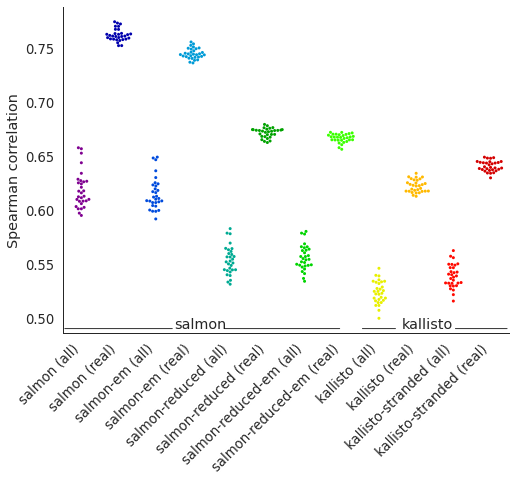

In [461]:
with sns.plotting_context("paper", font_scale=1.5):
    plt.figure(figsize=(8,6))
    ax = sns.swarmplot(data=corr_df_sub2, x='method', y='value',palette='nipy_spectral', dodge=True, size=3,
                      order=['salmon (all)', 'salmon (real)', 'salmon-em (all)', 'salmon-em (real)',
                             'salmon-reduced (all)', 'salmon-reduced (real)', 'salmon-reduced-em (all)',
                             'salmon-reduced-em (real)', 'kallisto (all)', 'kallisto (real)', 
                             'kallisto-stranded (all)', 'kallisto-stranded (real)'])
    
   
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Spearman correlation')
    plt.xlabel('')

    ax.annotate('salmon', xy=(2.5,0.49), xytext=(2.5,0.49))
    ax.annotate("", xy=(-0.5, 0.49), xytext=(2.5,0.49),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    ax.annotate("", xy=(7.0, 0.49), xytext=(3.8,0.49),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    
    ax.annotate('kallisto', xy=(8.6,0.49), xytext=(8.6,0.49))#, bbox=dict(boxstyle ="round", fc ="0.8"))
    ax.annotate("", xy=(7.5, 0.49), xytext=(8.5,0.49),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    ax.annotate("", xy=(10.0, 0.49), xytext=(11.5,0.49),
                textcoords='data', xycoords='data',
                arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
    sns.despine()
    plt.savefig('../figures/spearman.pdf', bbox_inches="tight")